### Higher Dimensional Example

While the previous example demonstrated the basic usage of the rescomp package, 
one very important part still needs to be discussed: The hyperparameters of RC.

To do so, here we look at a much higher dimensional system than before, the
Kuramoto Sivashinsky (KS) system, which we scale to be 22 dimensional.

As always we import the needed packages, create an ESNWrapper object

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import rescomp

esn = rescomp.ESNWrapper()

and simulate the system

In [5]:
simulation_time_steps = 100000
sim_data = rescomp.simulate_trajectory(
    sys_flag='kuramoto_sivashinsky', dimensions=100, system_size=22, dt=0.05,
    time_steps=simulation_time_steps)


As before, we want to train the system with data sampled from the chaotic
attractor we want to predict. As a result, we have to throw the first 1000
simulated data points away, as they are not on said attractor, but instead
correspond to transient system dynamics of the KS system.

In [6]:
sim_data = sim_data[1000:]

Now we again want to create the reservoir/network, but this time the default
parameters are not sufficient for RC to learn the system dynamics. For the KS
system the following parameters work:

In [7]:
n_dim = 5000  # network dimension
n_rad = 0.3  # spectral radius
n_avg_deg = 100  # average network degre

The more complicated and higher dimensional the system is, the larger the 
network n_dim needs to be.  
The spectral radius n_rad should be smaller than 1 and must be larger than 0.  
The average network degree n_avg_deg can, in theory, be everything in 
(0, n_dim]. Typically values larger than n_dim/10 are not optimal.  

These hyperparameters (and the ones below) have been found by trial and error 
for this system.  

So far no reliable heuristics exist for what the correct hyperparameter ranges
for an arbitrary system might be. See the FAQ for more details.

The numpy random seed, set to generate the same network everytime, is an
important hyperparameter too as different random networks can vary hugely in
their prediction performance even if all other hyperparameters are the same.

In [8]:
np.random.seed(0)

Finally, create the network with those parameters.

In [9]:
esn.create_network(n_dim=n_dim, n_rad=n_rad, n_avg_deg=n_avg_deg)

The train()/train_and_predict() methods too, have a set of hyperparameters one
needs to optimize. The most important of which are the regularization
parameter which is typically somewhere between 1e-2 and 1e-6

In [10]:
reg_param = 1e-2

and the scale of the random elements in the input matrix w_in which is usually
between 0.1 and 1.0

In [11]:
w_in_scale = 1.0

Define the number of training/prediction time steps

In [12]:
train_sync_steps = 1000
train_steps = 60000
pred_steps = 1500

and train+predict the system using the above hyperparameters.

In [13]:
y_pred, y_test = esn.train_and_predict(
    sim_data, train_sync_steps=train_sync_steps, train_steps=train_steps,
    pred_steps=pred_steps, reg_param=reg_param, w_in_scale=w_in_scale)

Plot the results

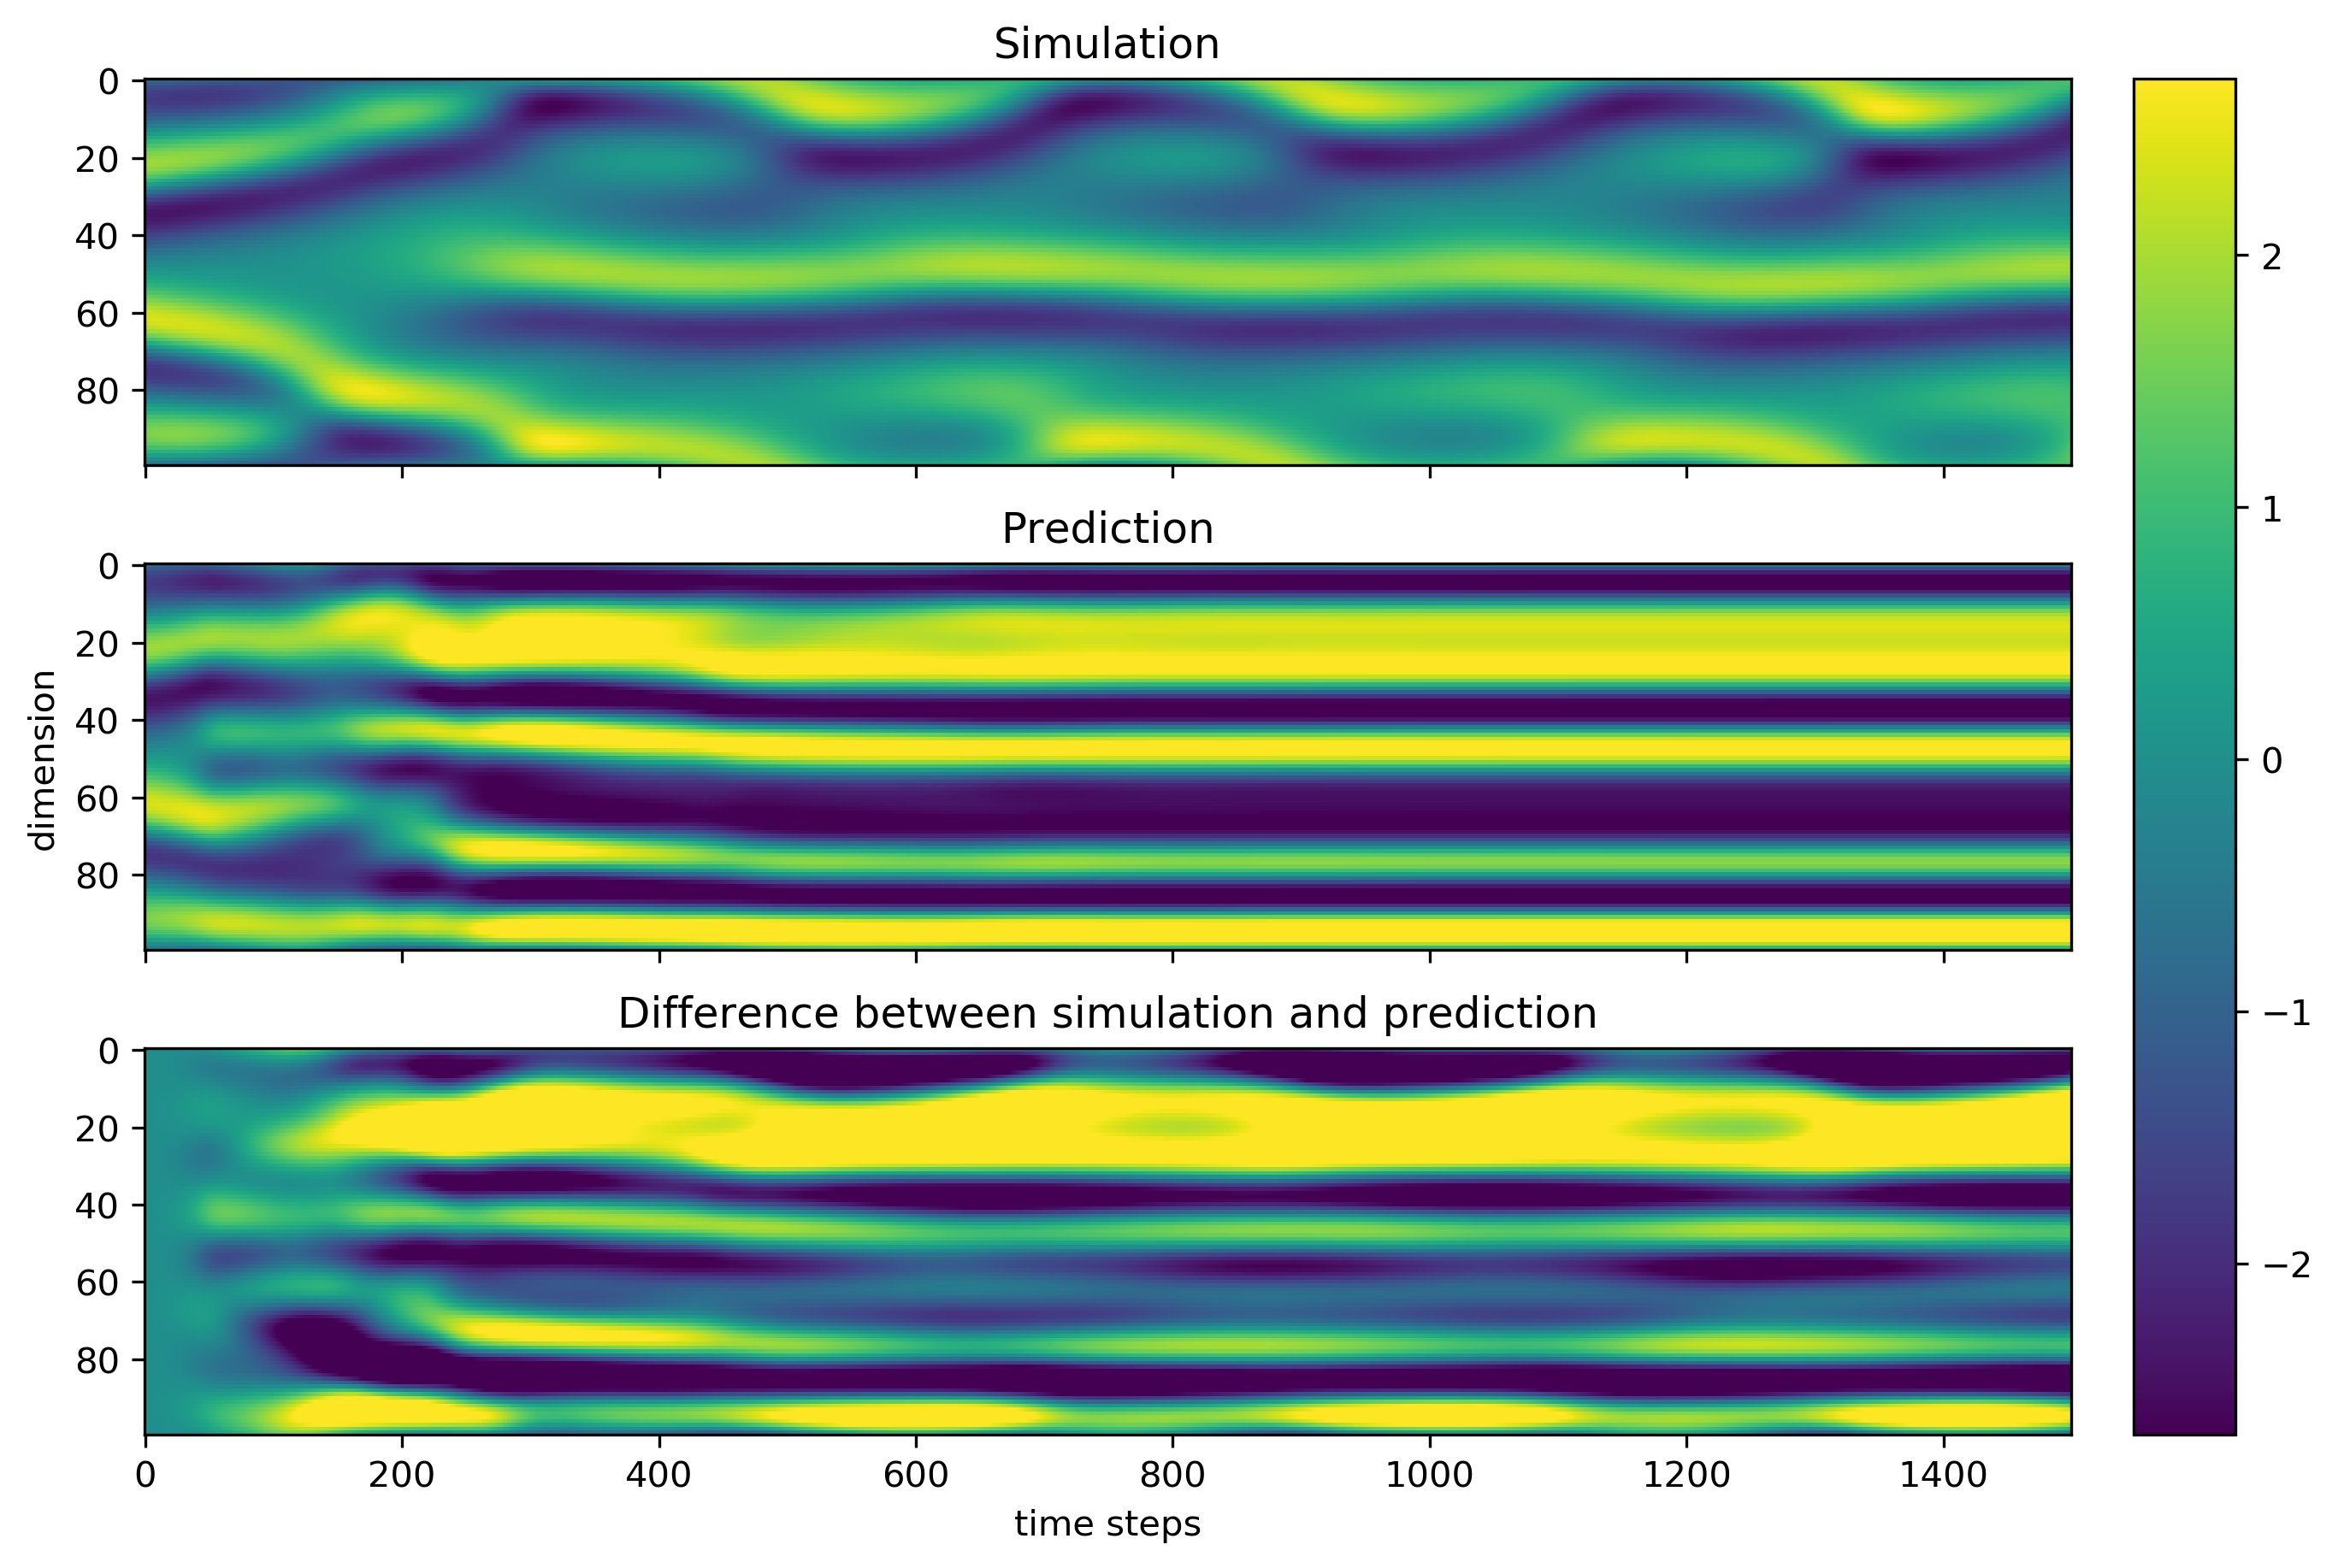

In [14]:
fig, axs = plt.subplots(3, 1, sharex="all", figsize=(9, 6),
                            constrained_layout=True, dpi=300)

vmin = np.min(y_test)
vmax = np.max(y_test)

im = axs[0].imshow(y_test.T, aspect='auto', vmin=vmin, vmax=vmax)
axs[0].set_title("Simulation")

axs[1].imshow(y_pred.T, aspect='auto', vmin=vmin, vmax=vmax)
axs[1].set_title("Prediction")

axs[2].imshow(y_pred.T - y_test.T, aspect='auto', vmin=vmin, vmax=vmax)
axs[2].set_title("Difference between simulation and prediction")

axs[1].set_ylabel("dimension")
axs[2].set_xlabel("time steps")
fig.colorbar(im, ax=axs)
plt.show()